In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models

In [2]:
# Print versions
!python --version
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

Python 3.7.6
Numpy 1.18.1
TensorFlow 2.1.0
Keras 2.2.4-tf


In [74]:
# Settings
raw_scale = 100             # Multiply raw values to fit into integers
sensor_sample_rate = 200    # Hz
desired_sample_rate = 50    # Hz
sample_time = 0.64          # Time (sec) length of each sample
samples_per_file = 128      # Expected number of measurements in each file (truncate to this)

max_measurements = int(sample_time * sensor_sample_rate)
downsample_factor = int(samples_per_file / desired_sample_rate)
win_len = int(max_measurements / downsample_factor)

keras_model_name = 'fan_low_model'           # Will be given .h5 suffix
tflite_model_name = 'fan_low_model'          # Will be given .tflite suffix
c_model_name = 'fan_low_model'               # Will be given .h suffix
c_hann_name = 'hann_window'                  # Will be given .h suffix
sample_file_name = 'normal_anomaly_samples'  # Will be given .npz suffix
rep_dataset_name = 'normal_anomaly_test_set' # Will be given .npz suffix

print('Max measurements per file:', max_measurements)
print('Downsample factor:', downsample_factor)
print('Window length:', win_len)

Max measurements per file: 128
Downsample factor: 2
Window length: 64


In [75]:
# Load model
model = models.load_model(keras_model_name + '.h5')

In [76]:
# Load test set
npzfile = np.load(rep_dataset_name + '.npz')
x_test = npzfile['x_test']

In [77]:
# Generator function that provides representative data samples for quantization
def representative_dataset_gen():
    for sample in x_test:
        sample = np.expand_dims(sample.astype(np.float32), axis=0)
        yield [sample]

In [85]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Quantization settings
#converter.representative_dataset = representative_dataset_gen

# Convert and save
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

11660

In [86]:
# Function: Convert some values into an array for C programming
def create_c_lookup_table(array, var_type, var_name, line_limit=80):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += 'const unsigned int ' + var_name + '_len = ' + str(len(array)) + ';\n'

    # Declare C variable
    c_str += 'const ' + var_type + ' ' + var_name + '[] = {\n'
    
    # Create string for the array
    indent = '  '
    array_str = indent
    line_len = len(indent)
    val_sep = ', '
    for i, val in enumerate(array):

        # Create a new line if string is over line limit
        val_str = str(val)
        if line_len + len(val_str) + len(val_sep) > line_limit:
            array_str += '\n' + indent
            line_len = len(indent)

        # Add value and separator
        array_str += val_str
        line_len += len(val_str)
        if (i + 1) < len(array):
            array_str += val_sep
            line_len += len(val_sep)

    # Add closing brace
    c_str += array_str + '\n};\n\n'

    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

In [87]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    hex_array = [format(val, '#04x') for val in tflite_model]
    file.write(create_c_lookup_table(hex_array, 'unsigned char', c_model_name))

In [81]:
# Create a hanning window lookup table
with open(c_hann_name + '.h', 'w') as file:
    file.write(create_c_lookup_table(np.hanning(win_len), 'float', c_hann_name))

In [82]:
# Load samples for testing
npzfile = np.load(sample_file_name + '.npz')
normal_sample = npzfile['normal_sample']
anomaly_sample = npzfile['anomaly_sample']

In [83]:
# Print out normal sample, truncated to 128 measurements
print("X")
for i in normal_sample[0:128, 0]:
    print(str(i), end=', ')
print()
print("Y")
for i in normal_sample[0:128, 1]:
    print(str(i), end=', ')
print()
print("Z")
for i in normal_sample[0:128, 2]:
    print(str(i), end=', ')

X
0.005859, 0.004395, 0.003418, 0.008301, 0.001953, 0.010254, 0.000977, -0.001465, 0.007324, 0.002441, -0.001953, 0.005859, -0.004395, 0.005859, -0.006836, 0.004883, 0.004395, 0.000977, 0.008301, -0.004395, 0.013184, 0.003418, -0.001465, 0.007813, 0.002441, 0.003418, 0.009277, 0.002441, 0.010254, -0.001465, 0.006836, 0.001465, 0.000977, 0.006836, -0.005859, 0.007813, 0.027832, -0.004395, 0.008301, 0.001465, 0.007813, 0.007324, 0.00293, 0.011719, 0.002441, 0.012695, 0.005371, 0.006348, 0.009277, 0.00293, 0.009277, 0.005371, -0.005371, 0.004883, -0.003906, 0.001953, 0.002441, -0.001465, 0.006348, -0.003906, 0.008301, 0.0, 0.006348, 0.008301, 0.001465, 0.010254, 0.012207, -0.000488, 0.013184, 0.000488, 0.006348, 0.003906, 0.00293, 0.008789, 0.000488, 0.005859, -0.000977, 0.00293, 0.003906, -0.000488, 0.01123, 0.011719, -0.00293, 0.006836, 0.002441, 0.00293, 0.006836, 0.00293, 0.008789, -0.002441, 0.007813, 0.003418, 0.007324, 0.005859, -0.002441, 0.000488, 0.005371, -0.000977, 0.008301, 0

In [84]:
# Print out anomaly sample, truncated to 128 measurements
print("X")
for i in anomaly_sample[0:128, 0]:
    print(str(i), end=', ')
print()
print("Y")
for i in anomaly_sample[0:128, 1]:
    print(str(i), end=', ')
print()
print("Z")
for i in anomaly_sample[0:128, 2]:
    print(str(i), end=', ')

X
0.019043, 0.025879, 0.021973, 0.020996, 0.022949, 0.01709, 0.022949, 0.017578, 0.024414, 0.021484, 0.020508, 0.020508, 0.017578, 0.023926, 0.025879, 0.021973, 0.026367, 0.020508, 0.025879, 0.020996, 0.027832, 0.026367, 0.018555, 0.025391, 0.021973, 0.022949, 0.024902, 0.020996, 0.022461, 0.019531, 0.016602, 0.026367, 0.022949, 0.022949, 0.021973, 0.024414, 0.023926, 0.021484, 0.023438, 0.018555, 0.027344, 0.023438, 0.02002, 0.024414, 0.023438, 0.021973, 0.020996, 0.020996, 0.025391, 0.020996, 0.023438, 0.022461, 0.021973, 0.022461, 0.019531, 0.023438, 0.022949, 0.02002, 0.025391, 0.023438, 0.023438, 0.024414, 0.019531, 0.026855, 0.023438, 0.027344, 0.018066, 0.021973, 0.024414, 0.022461, 0.021973, 0.024902, 0.022461, 0.021973, 0.020508, 0.024414, 0.022949, 0.020996, 0.022949, 0.022949, 0.023926, 0.021484, 0.02002, 0.027832, 0.021973, 0.020508, 0.023926, 0.024414, 0.024414, 0.021484, 0.023926, 0.024414, 0.021973, 0.021973, 0.021484, 0.025391, 0.022461, 0.020508, 0.023438, 0.020996, 0.

In [64]:
# Function: extract specified features (variances, MAD) from sample
def extract_features(sample, max_measurements=0, scale=1):
    
    features = []
    
    # Truncate sample
    if max_measurements == 0:
        max_measurements = sample.shape[0]
    sample = sample[0:max_measurements]
    
    # Scale sample
    sample = scale * sample
    
    # Compute a windowed FFT of each axis in the sample (leave off DC)
    sample = sample[::downsample_factor, :]  # Downsample
    sample = np.floor(sample)                # Round down to int
    hann_window = np.hanning(sample.shape[0])
    for i, axis in enumerate(sample.T):
        fft = abs(np.fft.rfft(axis * hann_window))
        features.append(fft[1:])  # Leave off DC
    
    return np.floor(np.array(features).flatten())

[0.000e+00 1.000e+00 3.000e+00 4.000e+00 4.000e+00 3.000e+00 2.000e+00
 1.000e+00 0.000e+00 0.000e+00 1.000e+00 5.000e+00 5.000e+00 1.000e+00
 1.000e+00 1.000e+00 3.000e+00 3.000e+00 0.000e+00 3.000e+00 5.000e+00
 3.000e+00 2.000e+00 2.000e+00 0.000e+00 2.000e+00 2.000e+00 1.000e+00
 2.000e+00 3.000e+00 1.000e+00 3.000e+00 2.090e+02 7.000e+00 5.000e+00
 1.500e+01 1.200e+01 2.000e+00 1.000e+00 1.000e+00 2.000e+00 1.000e+00
 2.000e+00 1.800e+01 2.500e+01 7.000e+00 1.000e+00 1.000e+00 4.000e+00
 3.000e+00 2.000e+00 2.000e+00 3.000e+00 3.000e+00 1.000e+00 2.000e+00
 4.000e+00 4.000e+00 3.000e+00 2.000e+00 3.000e+00 3.000e+00 2.000e+00
 0.000e+00 1.588e+03 1.700e+01 1.100e+01 9.000e+00 8.000e+00 1.000e+00
 2.000e+00 2.000e+00 4.000e+00 2.000e+00 4.000e+00 2.400e+01 3.100e+01
 1.000e+01 1.000e+00 1.000e+00 2.000e+00 3.000e+00 5.000e+00 5.000e+00
 5.000e+00 7.000e+00 3.000e+00 2.000e+00 0.000e+00 1.000e+00 1.000e+00
 1.000e+00 1.000e+00 2.000e+00 3.000e+00 1.000e+00]


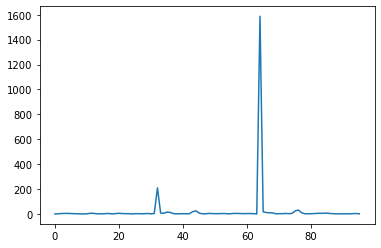

In [65]:
# Compute windowed FFT of each axis in normal sample
normal_fft = extract_features(normal_sample, max_measurements, raw_scale)
print(normal_fft)
plt.plot(normal_fft)

[2.900e+01 1.000e+00 2.000e+00 2.000e+00 1.000e+00 0.000e+00 1.000e+00
 0.000e+00 1.000e+00 1.000e+00 2.000e+00 2.000e+00 1.000e+00 0.000e+00
 1.000e+00 1.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 2.000e+00
 1.000e+00 1.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00 2.000e+00
 2.000e+00 1.000e+00 2.000e+00 3.000e+00 2.010e+02 1.000e+00 3.000e+00
 2.000e+00 1.000e+00 2.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00
 1.000e+00 6.000e+00 8.000e+00 2.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 0.000e+00 1.000e+00 1.000e+00 0.000e+00
 0.000e+00 0.000e+00 1.000e+00 2.000e+00 2.000e+00 0.000e+00 2.000e+00
 1.000e+00 1.583e+03 1.600e+01 9.000e+00 2.000e+00 3.000e+00 3.000e+00
 3.000e+00 2.000e+00 4.000e+00 5.000e+00 1.000e+00 1.000e+01 1.500e+01
 3.000e+00 3.000e+00 4.000e+00 4.000e+00 2.000e+00 3.000e+00 4.000e+00
 4.000e+00 4.000e+00 4.000e+00 2.000e+00 2.000e+00 2.000e+00 2.000e+00
 2.000e+00 2.000e+00 3.000e+00 0.000e+00 2.000e+00]


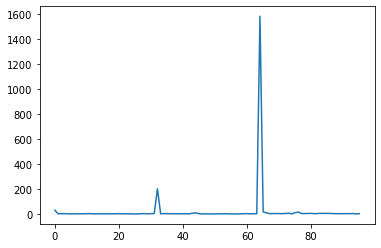

In [66]:
# Compute windowed FFT of each axis in anomaly sample
anomaly_fft = extract_features(anomaly_sample, max_measurements, raw_scale)
print(anomaly_fft)
plt.plot(anomaly_fft)

In [67]:
# Copy in Arduino FFTs for normal sample
arduino_fft_normal_x = [11, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 3, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 1, 2, 3, 0]
arduino_fft_normal_y = [330, 3, 4, 13, 10, 1, 0, 1, 0, 0, 4, 24, 32, 8, 2, 3, 2, 1, 2, 0, 3, 1, 0, 2, 0, 1, 1, 1, 2, 5, 2, 2]
arduino_fft_normal_z = [2493, 30, 9, 5, 0, 4, 3, 4, 2, 3, 7, 29, 42, 19, 0, 0, 1, 1, 0, 0, 5, 6, 1, 2, 2, 1, 2, 3, 3, 0, 1, 4]
arduino_fft_anomaly_x = [54, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 3, 3, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 2, 1, 0, 4, 3]
arduino_fft_anomaly_y = [325, 1, 4, 1, 1, 3, 1, 1, 1, 1, 0, 7, 10, 4, 0, 0, 1, 0, 0, 0, 0, 4, 2, 0, 0, 0, 1, 1, 0, 1, 0, 0]
arduino_fft_anomaly_z = [2490, 22, 15, 3, 10, 3, 0, 3, 3, 4, 1, 17, 22, 6, 1, 0, 2, 2, 1, 1, 4, 5, 2, 1, 1, 3, 1, 1, 1, 0, 2, 1]

(96,)


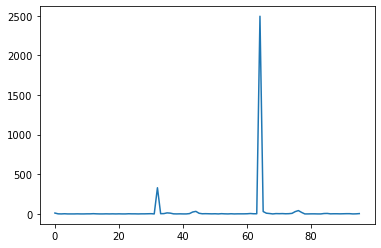

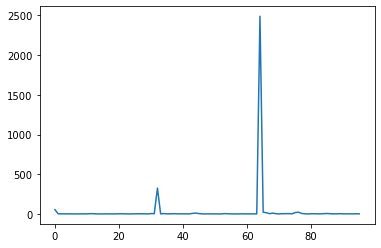

In [16]:
# Create feature set from Arduino FFTs
arduino_fft_normal = np.array([arduino_fft_normal_x, arduino_fft_normal_y, arduino_fft_normal_z]).flatten()
arduino_fft_anomaly = np.array([arduino_fft_anomaly_x, arduino_fft_anomaly_y, arduino_fft_anomaly_z]).flatten()
print(arduino_fft_normal.shape)
plt.plot(arduino_fft_normal)
plt.figure()
plt.plot(arduino_fft_anomaly)

[[  11    1    0    2    0    0    0    1    0    0    1    1    3    1
     0    0    1    0    1    0    1    0    0    2    1    1    0    1
     1    2    3    0  330    3    4   13   10    1    0    1    0    0
     4   24   32    8    2    3    2    1    2    0    3    1    0    2
     0    1    1    1    2    5    2    2 2493   30    9    5    0    4
     3    4    2    3    7   29   42   19    0    0    1    1    0    0
     5    6    1    2    2    1    2    3    3    0    1    4]]
[[   0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.        299.82224     0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.         25.196068   

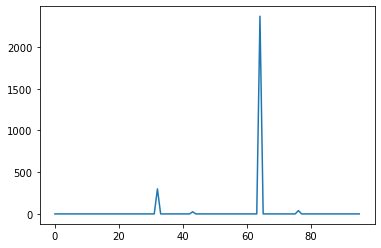

In [44]:
# Test arduino FFT normal in full model NN
input_tensor = arduino_fft_normal.reshape(1, -1)
print(input_tensor)
predictions = model.predict(input_tensor)
print(predictions)
plt.plot(predictions[0])
mse = np.mean(np.power(input_tensor - predictions, 2), axis=1)
print(mse)

[[  54    2    1    1    0    1    0    0    1    0    1    3    3    0
     0    0    1    0    0    1    1    2    1    0    0    1    2    2
     1    0    4    3  325    1    4    1    1    3    1    1    1    1
     0    7   10    4    0    0    1    0    0    0    0    4    2    0
     0    0    1    1    0    1    0    0 2490   22   15    3   10    3
     0    3    3    4    1   17   22    6    1    0    2    2    1    1
     4    5    2    1    1    3    1    1    1    0    2    1]]
[[   0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.          0.        293.42096     0.          0.          0.
     0.          0.          0.          0.          0.          0.
     0.         24.671133   

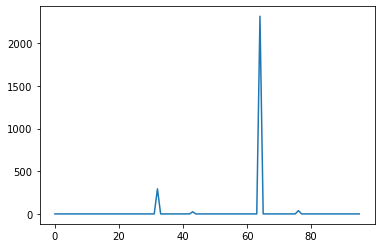

In [47]:
# Test arduino FFT anomaly in full model NN
input_tensor = arduino_fft_anomaly.reshape(1, -1)
print(input_tensor)
predictions = model.predict(input_tensor)
print(predictions)
plt.plot(predictions[0])
mse = np.mean(np.power(input_tensor - predictions, 2), axis=1)
print(np.power(input_tensor - predictions, 2))
print(mse)

MSE: 1.5208333333333333


Text(0.5, 1.0, 'Predictions')

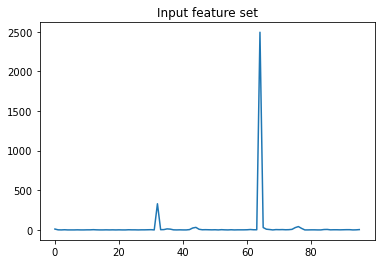

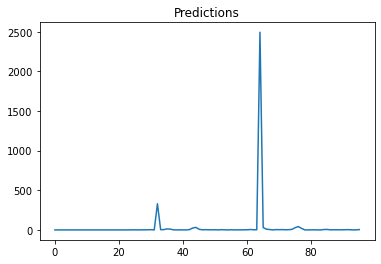

In [50]:
# Arduino NN output for normal sample
arduino_feature_set = [11.00, 1.00, 0.00, 2.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 1.00, 3.00, 1.00, 0.00, 0.00, 1.00, 0.00, 1.00, 0.00, 1.00, 0.00, 0.00, 2.00, 1.00, 1.00, 0.00, 1.00, 1.00, 2.00, 3.00, 0.00, 330.00, 3.00, 4.00, 13.00, 10.00, 1.00, 0.00, 1.00, 0.00, 0.00, 4.00, 24.00, 32.00, 8.00, 2.00, 3.00, 2.00, 1.00, 2.00, 0.00, 3.00, 1.00, 0.00, 2.00, 0.00, 1.00, 1.00, 1.00, 2.00, 5.00, 2.00, 2.00, 2493.00, 30.00, 9.00, 5.00, 0.00, 4.00, 3.00, 4.00, 2.00, 3.00, 7.00, 29.00, 42.00, 19.00, 0.00, 0.00, 1.00, 1.00, 0.00, 0.00, 5.00, 6.00, 1.00, 2.00, 2.00, 1.00, 2.00, 3.00, 3.00, 0.00, 1.00, 4.00]
arduino_predictions = [-0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, -0.00, 1.00, 1.00, 0.00, 1.00, 1.00, 2.00, 3.00, 0.00, 330.00, 3.00, 4.00, 13.00, 10.00, 1.00, 0.00, 1.00, 0.00, 0.00, 4.00, 24.00, 32.00, 8.00, 2.00, 3.00, 2.00, 1.00, 2.00, 0.00, 3.00, 1.00, 0.00, 2.00, 0.00, 1.00, 1.00, 1.00, 2.00, 5.00, 2.00, 2.00, 2493.00, 30.00, 9.00, 5.00, 0.00, 4.00, 3.00, 4.00, 2.00, 3.00, 7.00, 29.00, 42.00, 19.00, 0.00, 0.00, 1.00, 1.00, 0.00, 0.00, 5.00, 6.00, 1.00, 2.00, 2.00, 1.00, 2.00, 3.00, 3.00, 0.00, 1.00, 4.00]
mse = np.mean(np.power(np.array(arduino_feature_set) - np.array(arduino_predictions), 2))
print('MSE:', mse)

plt.plot(arduino_feature_set)
plt.title('Input feature set')
plt.figure()
plt.plot(arduino_predictions)
plt.title('Predictions')

MSE: 30.739583333333332


Text(0.5, 1.0, 'Predictions')

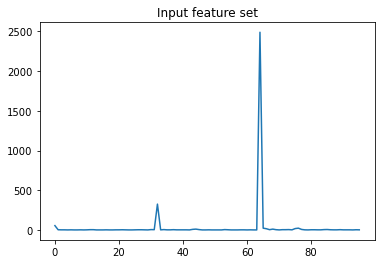

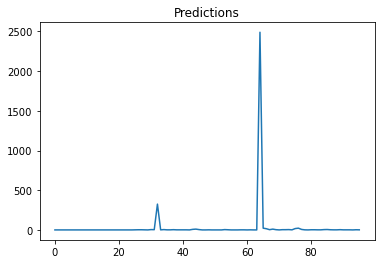

In [49]:
# Arduino NN output for anomaly sample
arduino_feature_set = [54.00, 2.00, 1.00, 1.00, 0.00, 1.00, 0.00, 0.00, 1.00, 0.00, 1.00, 3.00, 3.00, 0.00, 0.00, 0.00, 1.00, 0.00, 0.00, 1.00, 1.00, 2.00, 1.00, 0.00, 0.00, 1.00, 2.00, 2.00, 1.00, 0.00, 4.00, 3.00, 325.00, 1.00, 4.00, 1.00, 1.00, 3.00, 1.00, 1.00, 1.00, 1.00, 0.00, 7.00, 10.00, 4.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 4.00, 2.00, 0.00, 0.00, 0.00, 1.00, 1.00, 0.00, 1.00, 0.00, 0.00, 2490.00, 22.00, 15.00, 3.00, 10.00, 3.00, 0.00, 3.00, 3.00, 4.00, 1.00, 17.00, 22.00, 6.00, 1.00, 0.00, 2.00, 2.00, 1.00, 1.00, 4.00, 5.00, 2.00, 1.00, 1.00, 3.00, 1.00, 1.00, 1.00, 0.00, 2.00, 1.00] 
arduino_predictions = [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00, 2.00, 2.00, 1.00, 0.00, 4.00, 3.00, 325.00, 1.00, 4.00, 1.00, 1.00, 3.00, 1.00, 1.00, 1.00, 1.00, 0.00, 7.00, 10.00, 4.00, 0.00, 0.00, 1.00, 0.00, 0.00, 0.00, 0.00, 4.00, 2.00, 0.00, 0.00, 0.00, 1.00, 1.00, 0.00, 1.00, 0.00, 0.00, 2490.00, 22.00, 15.00, 3.00, 10.00, 3.00, 0.00, 3.00, 3.00, 4.00, 1.00, 17.00, 22.00, 6.00, 1.00, 0.00, 2.00, 2.00, 1.00, 1.00, 4.00, 5.00, 2.00, 1.00, 1.00, 3.00, 1.00, 1.00, 1.00, 0.00, 2.00, 1.00] 
mse = np.mean(np.power(np.array(arduino_feature_set) - np.array(arduino_predictions), 2))
print('MSE:', mse)

plt.plot(arduino_feature_set)
plt.title('Input feature set')
plt.figure()
plt.plot(arduino_predictions)
plt.title('Predictions')